In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.analytical.coronographs import LyotCoronograph, PerfectCoronograph, KnifeEdgeCoronograph, FourQuadrantCoronograph, VortexCoronograph
from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def imageShow(image2d, pixelSize=1, title='', xlabel=r'$\lambda/D$', ylabel=r'$\lambda/D$', zlabel=''):
    sz=image2d.shape
    plt.imshow(xp.asnumpy(image2d), extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize],
                                cmap='twilight',vmin=-24)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar()
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, maxLogVal = None, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    if maxLogVal is None:
        maxLogVal = xp.max(imageZoomedLog)
    imageZoomedLog -= maxLogVal
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

In [3]:
def show_coronograph_prop(coro, maxLogPsf=None):
    plt.figure(figsize=(22,4))
    plt.subplot(1,4,1)
    fcmap = 'RdBu' if xp.max(coro.focal_mask) > 1.0 else 'grey'
    phase = xp.angle(xp.exp(1j*coro.focal_mask))
    phase += 2*xp.pi * (phase < 0.0)
    plt.imshow(xp.asnumpy(phase),cmap=fcmap,origin='lower')
    plt.title('Focal plane mask')
    plt.colorbar()
    plt.subplot(1,4,2)
    showZoomCenter(xp.abs(coro._focal_field)**2,1/coro.oversampling,title='PSF at focal mask',maxLogVal=maxLogPsf)
    plt.subplot(1,4,3)
    plt.imshow(xp.asnumpy(coro.pupil_mask),cmap='grey',origin='lower')
    plt.title('Pupil stop')
    plt.subplot(1,4,4)
    showZoomCenter(xp.abs(coro._focal_coro_field)**2,1/coro.oversampling,title='Coronographic PSF',maxLogVal=maxLogPsf)


In [4]:
ssao = SingleStageAO(tn='high_contrast')
ssao.initialize_turbulence(tn='ekarus_10cm')

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Fried parameter is: 10.0 [cm] (seeing = 1.01")


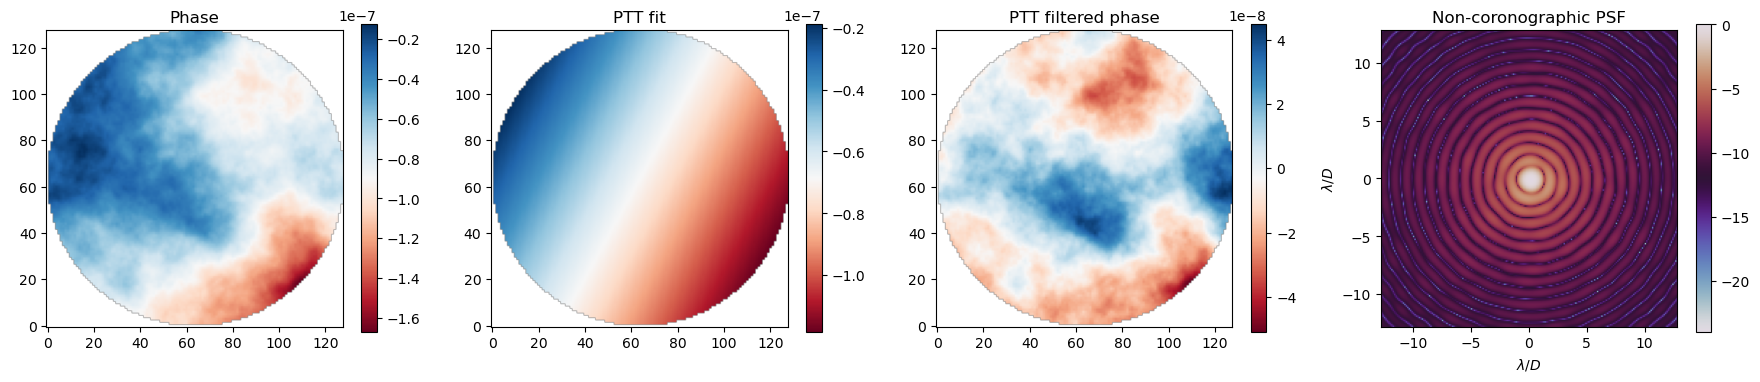

In [5]:
phase = ssao.get_phasescreen_at_time(0.0)
cmask = ssao.cmask.copy()
amp = 30e-9

phi = phase[~cmask]
phi *= amp/xp.std(phi)

X,Y = image_grid(cmask.shape,recenter=True)
tip = X[~cmask]
tilt = Y[~cmask]
piston = xp.ones(int(xp.sum(1-cmask)))
ptt = xp.vstack([piston,tip,tilt]).T
phase2ptt = xp.linalg.pinv(ptt)

ptt_coeffs = phase2ptt @ phi
ptt_phi = ptt @ ptt_coeffs
phi_filt = reshape_on_mask(phi - ptt_phi,cmask)

lambdaInM = 700e-9
oversampling = 8

input_field = (1-cmask) * xp.exp(1j*phi_filt*2*xp.pi/lambdaInM,dtype=xp.complex64)
pad_width = int(max(input_field.shape)*(oversampling-1))//2
padded_field = xp.pad(input_field,pad_width=pad_width,mode='constant',constant_values=0.0)
psf = abs(xp.fft.fftshift(xp.fft.fft2(padded_field)))**2

maxLogPsf = xp.max(xp.log(psf))

plt.figure(figsize=(22,4))
plt.subplot(1,4,1)
plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(phi,cmask)),mask=xp.asnumpy(cmask)),origin='lower',cmap='RdBu')
plt.title('Phase')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(ptt_phi,cmask)),mask=xp.asnumpy(cmask)),origin='lower',cmap='RdBu')
plt.title('PTT fit')
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(masked_array(xp.asnumpy(phi_filt),mask=xp.asnumpy(cmask)),origin='lower',cmap='RdBu')
plt.title('PTT filtered phase')
plt.colorbar()
plt.subplot(1,4,4)
showZoomCenter(psf, 1/oversampling, maxLogVal=maxLogPsf, title='Non-coronographic PSF')

1048576 12849


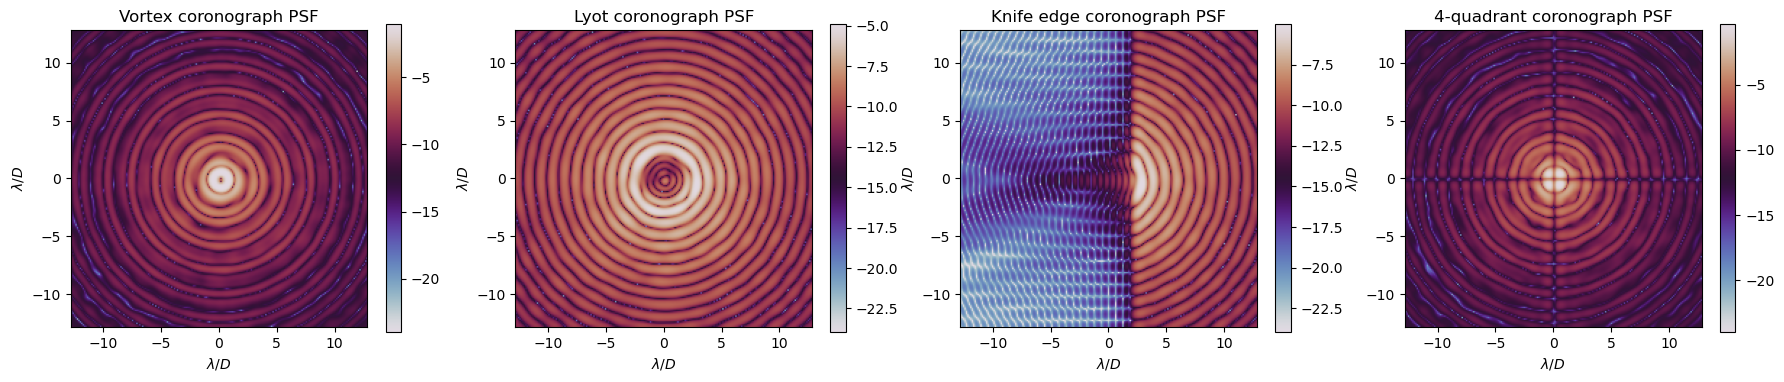

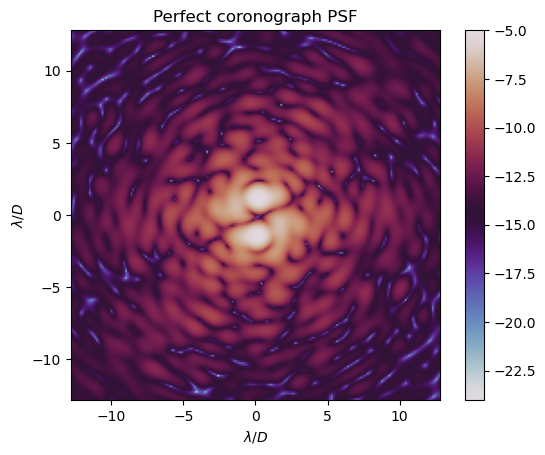

In [ ]:
lyot = LyotCoronograph(inFocalStopInLambdaOverD=2.0, outPupilStopInFractionOfPupil=0.95)#, outFocalStopInLambdaOverD=30,  inPupilStopInFractionOfPupil=0.1)
perfCoro = PerfectCoronograph()
kedge = KnifeEdgeCoronograph(iwaFocalStopInLambdaOverD=2.0, outPupilStopInFractionOfPupil=0.95)
fquad = FourQuadrantCoronograph(outPupilStopInFractionOfPupil=0.95)
vortex = VortexCoronograph(charge=6,outPupilStopInFractionOfPupil=0.95)

lyot_psf = lyot.get_coronographic_psf(input_field, oversampling)
perfect_coro_psf = perfCoro.get_coronographic_psf(input_field, oversampling)
kedge_psf = kedge.get_coronographic_psf(input_field,oversampling)
fquad_psf = fquad.get_coronographic_psf(input_field,oversampling)
vortex_psf = vortex.get_coronographic_psf(input_field,oversampling)


plt.figure(figsize=(22,4))
plt.subplot(1,4,1)
showZoomCenter(vortex_psf, 1/oversampling, maxLogVal=maxLogPsf, title='Vortex coronograph PSF')
plt.subplot(1,4,2)
showZoomCenter(lyot_psf, 1/oversampling, maxLogVal=maxLogPsf, title='Lyot coronograph PSF')
plt.subplot(1,4,3)
showZoomCenter(kedge_psf, 1/oversampling, maxLogVal=maxLogPsf, title='Knife edge coronograph PSF')
plt.subplot(1,4,4)
showZoomCenter(fquad_psf, 1/oversampling, maxLogVal=maxLogPsf, title='4-quadrant coronograph PSF')

plt.figure()
showZoomCenter(perfect_coro_psf, 1/oversampling, maxLogVal=maxLogPsf, title='Perfect coronograph PSF')

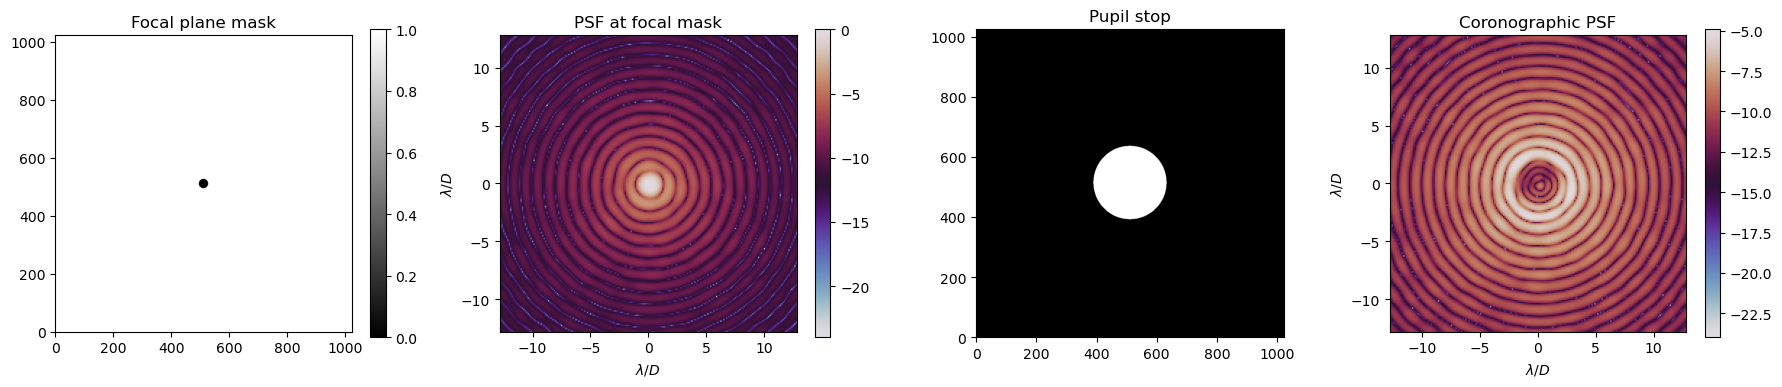

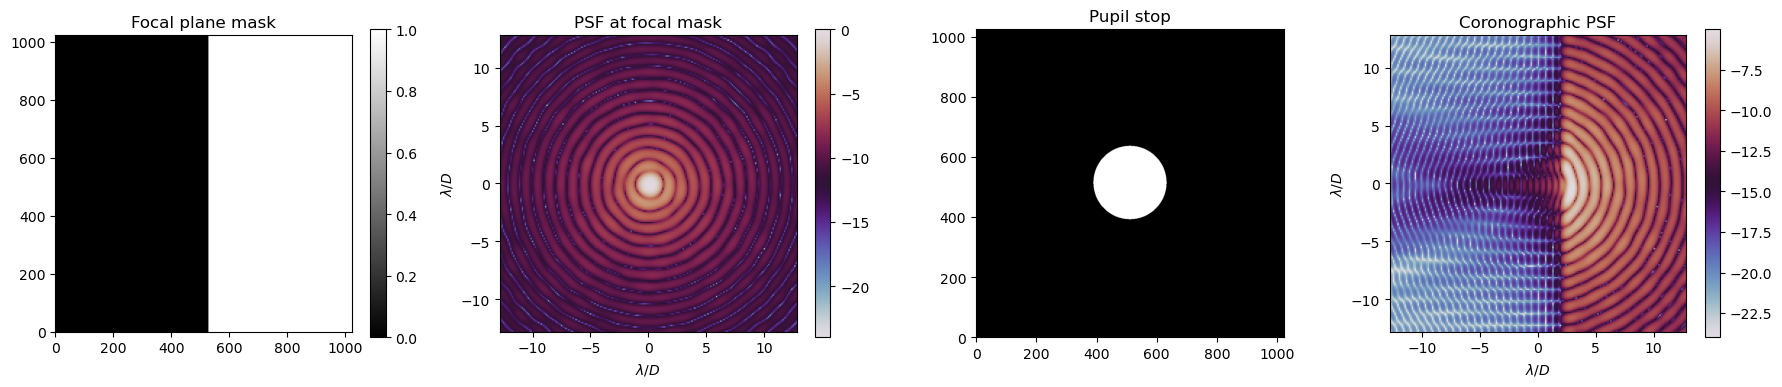

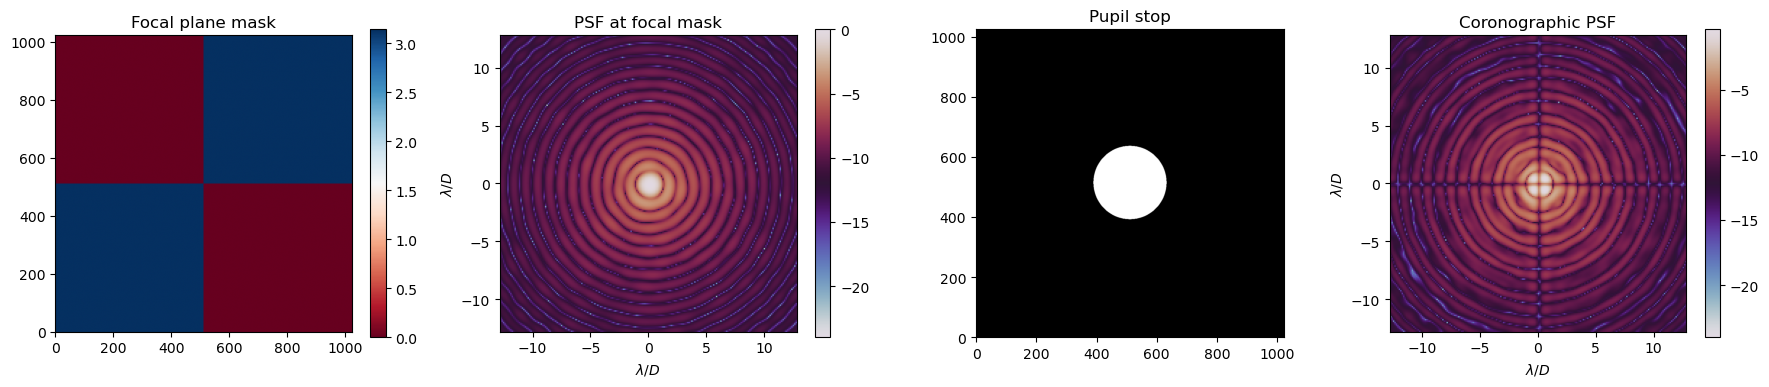

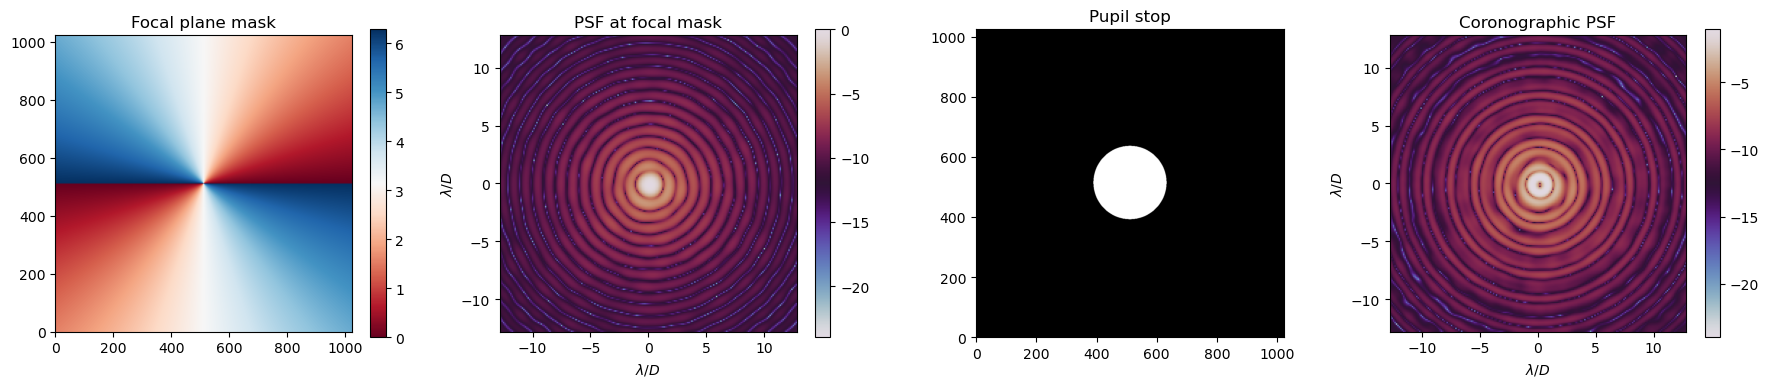

In [7]:
show_coronograph_prop(lyot,maxLogPsf)
show_coronograph_prop(kedge,maxLogPsf)
show_coronograph_prop(fquad,maxLogPsf)
show_coronograph_prop(vortex,maxLogPsf)